# Hough Transform Testing

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
import random
from PIL import Image

In [6]:
# Find all normal lines from point pairs
def points2lines(points):
    lines = np.zeros([1,3])
    r,c = points.shape
    while(r>1):
        for i in np.arange(1,r):
            line = np.cross(points[0,:], points[i,:])
            lines = np.vstack([lines, line])
        points = points[1:,:]
        r,c = points.shape
    lines = lines[1:,:]
 
    return lines


# Convert linear eqn to rho-theta
def plane2hough(lines):

    slope = -lines[0]/lines[1]
    theta = math.atan(-1/slope)
    if theta !=(0):
        b = -lines[2]/lines[1]
        x = -b/(slope+1/slope)
        y = slope*x + b
        rho = x*np.cos(theta) + y*np.sin(theta)
    else:
        rho = -lines[2]/lines[0]
    rhotheta = [rho, theta]

    return rhotheta


# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):

    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray

# RANSAC
"The input to the RANSAC algorithm is a set of observed data values, a way of fitting some kind of model to the observations, and some confidence parameters. RANSAC achieves its goal by repeating the following steps:

1. Select a random subset of the original data. Call this subset the hypothetical inliers.
2. A model is fitted to the set of hypothetical inliers.
3. All other data are then tested against the fitted model. Those points that fit the estimated model well, according to some model-specific loss function, are considered as part of the consensus set.
4. The estimated model is reasonably good if sufficiently many points have been classified as part of the consensus set.
5. Afterwards, the model may be improved by reestimating it using all members of the consensus set.

This procedure is repeated a fixed number of times, each time producing either a model which is rejected because too few points are part of the consensus set, or a refined model together with a corresponding consensus set size. In the latter case, we keep the refined model if its consensus set is larger than the previously saved model."

https://en.wikipedia.org/wiki/Random_sample_consensus

In [7]:
def RANSAC(data,e,s,threshold):
    # data = contaminated points
    # e = probablility that point is an outlier
    # s = min number of points needed to fit model
    # threshold = allowed distance from model to surrounding points

    # Calculate how many points match the model
    def getInliers(pair,data,threshold):

        # Convert edgels to (a,b,c)
        plane = points2lines(pair)
        plane = np.concatenate(plane)
        
        # Edgel distance to plane
        plane_norm = np.sqrt(np.sum(plane[0:2]**2))
        dist = np.abs(np.dot(data,plane.T)) / plane_norm
        
        inliers = data[dist <= threshold]
        inliers = inliers.astype(int)

        return inliers

    # Find data points that best fit the data
    def findfit(N,T,data,threshold):
        votes = np.zeros(data.shape[1]+1)
        i = 0
        while i < N:
            # Find two random edgels
            pair = np.random.randint(data.shape[0],size=2)

            # Insure pairs are unique
            while pair[0] == pair[1]:
                pair[1] = np.random.randint(data.shape[0])
            point_pair = data[pair]

            inliers = getInliers(point_pair,data,threshold)
            num_inlier = np.sum(inliers[:,2])

            if num_inlier > votes[0]:
                votes = np.hstack([num_inlier, np.reshape(point_pair,2*data.shape[1])])
                
                if num_inlier >= T:
                    break

            i += 1
        return votes

    # Add a column of 1's to the end
    r,c = data.shape
    data = np.hstack([data, np.ones([r,1])])
         
    # probability that one sample is clean
    p = 0.99

    # number of samples needed
    N = np.log(1-p) / np.log(1-(1-e)**s)
    N = np.int(np.round(N))

    # Stop search when this number has been reached
    T = (1-e)*data.shape[0]

    # Fit with all data
    votes = findfit(N,T,data,threshold)
    
    # Refit with only inliers
    pair = np.reshape(votes[1:], (2,data.shape[1]))
    inliers = getInliers(pair,data,threshold)

    # Reduce error and threshold
    e = e/4
    threshold = threshold/3
    T = (1-e)*inliers.shape[0]
    votes = findfit(N,T,inliers,threshold)
    pair = np.reshape(votes[1:],(2,3))
    inliers = getInliers(pair,data,threshold)

    plane = points2lines(pair)
    plane = np.concatenate(plane)
    rhotheta = plane2hough(plane)

    print(plane)
    print(rhotheta)
    return inliers[:,0:2]

In [63]:
file = 'edges.jpg'
im = Image.open(file)

r,c = im.size
r = np.int(np.floor(r/5))
c = np.int(np.floor(c/5))

im = im.resize((r,c))
gray = rgb2gray(im)

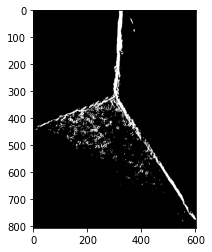

In [64]:
dim = 7
box = np.ones([dim,dim])/dim**2

smooth = nd.convolve(gray,box)

Ix = Sobelx(smooth)
Iy = Sobely(smooth)
mag = np.sqrt(Ix**2+Iy**2)

threshold = 0.25
mask = 1*( mag >= threshold*np.amax(mag))
plt.imshow(mask, cmap='gray')

[  232.  -363. 37938.]
[-88.06303243408003, -1.0021087710235703]
2


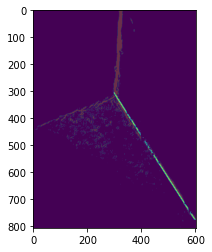

In [65]:
edgels = np.where(mask==1)
edgels = np.array(edgels).T

# Execute RANSAC
e = 0.75
model = 2
threshold = 5
inliers = RANSAC(edgels,e,model,threshold)
print(model)

# Plot the results
good = np.zeros([mask.shape[0], mask.shape[1]])
good[inliers[:,0], inliers[:,1]] = 1
plt.imshow(mask)
plt.imshow(good, alpha = 0.8)